In [37]:
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.plotting import autocorrelation_plot

# Caminho relativo até a pasta do CSV
script_dir = os.getcwd()
csv_path = os.path.join(script_dir, "../simple_prophet_forecast/Coffe_sales.csv")
csv_path = os.path.abspath(csv_path)

df = pd.read_csv(csv_path)

df.head()

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


In [38]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour_of_day  3547 non-null   int64  
 1   cash_type    3547 non-null   object 
 2   money        3547 non-null   float64
 3   coffee_name  3547 non-null   object 
 4   Time_of_Day  3547 non-null   object 
 5   Weekday      3547 non-null   object 
 6   Month_name   3547 non-null   object 
 7   Weekdaysort  3547 non-null   int64  
 8   Monthsort    3547 non-null   int64  
 9   Date         3547 non-null   object 
 10  Time         3547 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 304.9+ KB


(3547, 11)

In [39]:
df.columns = df.columns.str.replace(' ','_').str.lower() 

In [40]:
# Padronizando em 'snake_case'

print('número de hífens:',df['date'].str.contains('-').sum())
print('número de espaços:',df['date'].str.contains(' ').sum())


número de hífens: 3547
número de espaços: 0


In [41]:
df_prophet = df.groupby('date')['money'].sum().reset_index()
df_prophet = df_prophet.rename(columns={'date':'ds','money':'y'})
df_prophet.columns = ['ds', 'y']

In [42]:
df_prophet.head()

,ds,y
0,2024-03-01,396.3
1,2024-03-02,188.1
2,2024-03-03,309.1
3,2024-03-04,135.2
4,2024-03-05,338.5


In [43]:
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="mixed")
df_weekly = df_prophet.resample('W-MON', on='ds').sum().reset_index()
df_weekly.head()


,ds,y
0,2024-03-04,1028.7
1,2024-03-11,1545.5
2,2024-03-18,1171.7
3,2024-03-25,1120.8
4,2024-04-01,1241.3


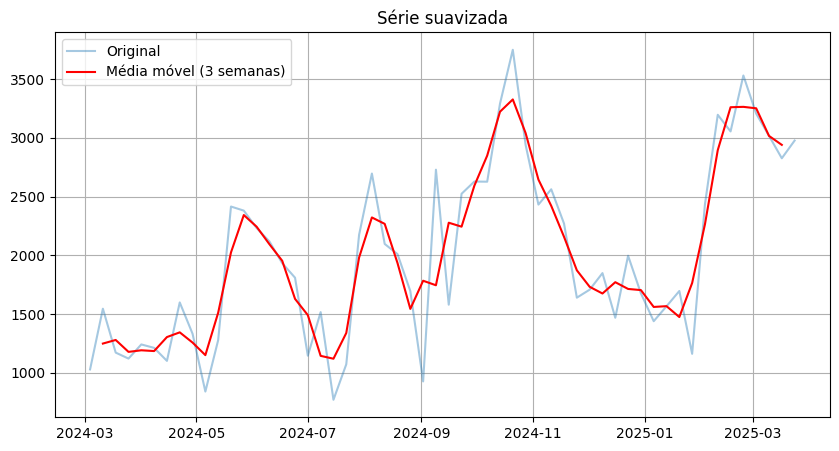

In [44]:
# Aqui, podemos observar que trata-se de uma série ruidosa, sem padrão sazonal consistente
df_weekly['y_smooth'] = df_weekly['y'].rolling(3, center=True).mean() # Média móvel de 3 semanas

plt.figure(figsize=(10,5))
plt.plot(df_weekly['ds'], df_weekly['y'], label='Original', alpha=0.4)
plt.plot(df_weekly['ds'], df_weekly['y_smooth'], label='Média móvel (3 semanas)', color='red')
plt.title('Série suavizada')
plt.legend()
plt.grid()
plt.show()

In [45]:
H = 8  
train =  df_weekly.iloc[-H:][['ds','y_smooth']].dropna().rename(columns={'y_smooth':'y'})
test  = df_weekly.iloc[-H:][['ds', 'y_smooth']].rename(columns={'y_smooth': 'y'})

21:17:57 - cmdstanpy - INFO - Chain [1] start processing
21:17:57 - cmdstanpy - INFO - Chain [1] done processing


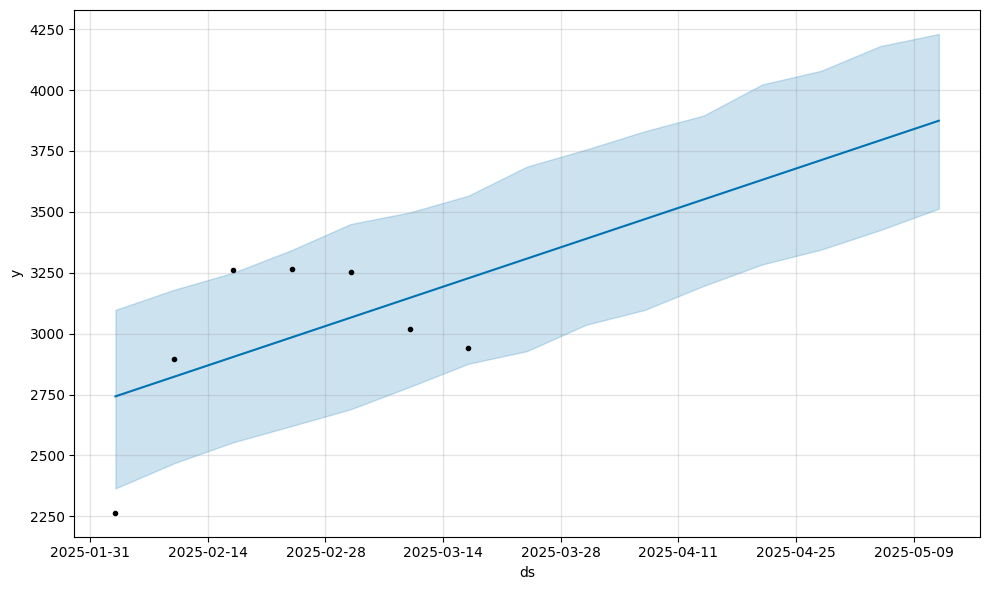

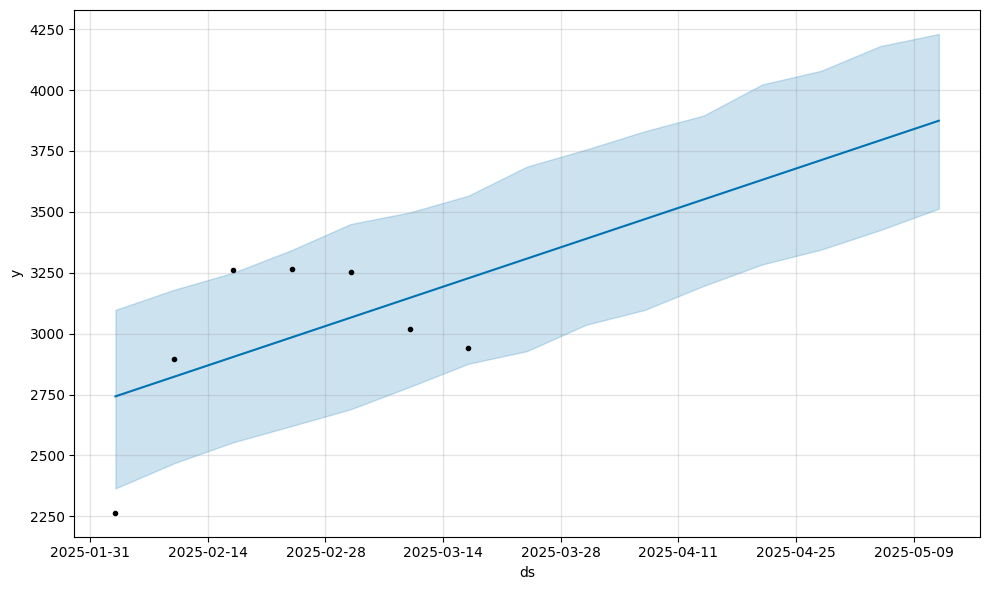

In [46]:
m = Prophet()

m.fit(train.rename(columns={'ds': 'ds', 'y': 'y'}))

future = m.make_future_dataframe(periods=H, freq='W-MON')
forecast = m.predict(future)

m.plot(forecast)


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

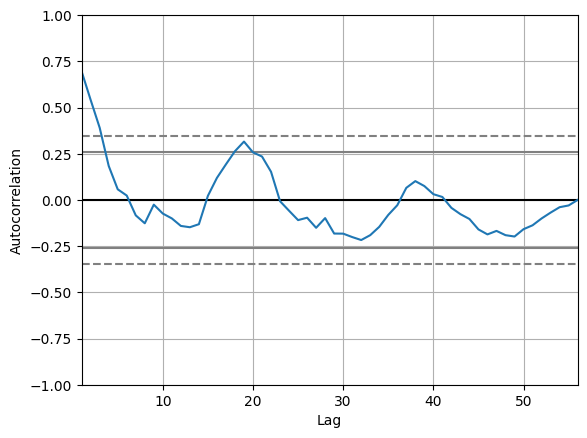

In [47]:
# Avaliação do modelo

autocorrelation_plot(df_weekly['y'])

In [48]:
# Métricas de avaliação

eval_df = forecast[['ds','yhat']].merge(test, on='ds', how='right')
eval_df = eval_df.rename(columns={'y':'y_true', 'yhat':'y_pred'})
eval_df.dropna(inplace=True)
mae  = mean_absolute_error(eval_df['y_true'], eval_df['y_pred'])
rmse = np.sqrt(mean_squared_error(eval_df['y_true'], eval_df['y_pred']))
r2   = r2_score(eval_df['y_true'], eval_df['y_pred'])

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

MAE : 255.65
RMSE: 286.11
R²  : 0.242
